# COVID-19 Data Analysis
- Data is provided Johns Hopkins University <a href='https://github.com/CSSEGISandData/COVID-19'>here</a>

In [0]:
# Import libraries
import shutil
import os
import stat
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from tensorflow import keras
import tensorflow as tf
import numpy as np
import folium
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from datetime import datetime, timedelta
from tqdm.notebook import tqdm
import tensorflow_addons as tfa

%matplotlib inline

In [0]:
WORKING_DIR = "drive/My Drive/colab/covid-19-analysis"

In [0]:
# Declare important variables
raw_data_path = f'{WORKING_DIR}/raw_data/'
confirmed_data_path = raw_data_path + 'csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
death_data_path = raw_data_path + 'csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
recovered_data_path = raw_data_path + 'csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

In [0]:
# Run this cell to get latest data (For local)
# def handle_remove_readonly(func, path, exc):
#     if not os.access(path, os.W_OK):
#         os.chmod(path, stat.S_IWUSR)
#         func(path)
#     else:
#         raise
        
# if(os.path.exists(raw_data_path)):
#     shutil.rmtree(raw_data_path, onerror=handle_remove_readonly)
    
# !git clone https://github.com/CSSEGISandData/COVID-19.git $raw_data_path

In [4]:
# Run this cell to get latest data (For google colab)
!rm -rf $raw_data_path
!git clone 'https://github.com/CSSEGISandData/COVID-19.git' '$raw_data_path'

Cloning into 'drive/My Drive/colab/covid-19-analysis/raw_data'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 31424 (delta 20), reused 28 (delta 15), pack-reused 31379
Receiving objects: 100% (31424/31424), 156.03 MiB | 26.46 MiB/s, done.
Resolving deltas: 100% (18409/18409), done.


## Data Analysis

### Worldwide cases analytic

In [0]:
# Declare dataframe
df_confirmed = pd.read_csv(confirmed_data_path)
df_death = pd.read_csv(death_data_path)
df_recovered = pd.read_csv(recovered_data_path)

In [6]:
# Covid cases distribution
map_view = folium.Map(location=[10,0], zoom_start=2,max_zoom=6,min_zoom=2)
for i in range(0,len(df_confirmed)):
    folium.Circle(
        location=[df_confirmed.iloc[i]['Lat'], df_confirmed.iloc[i]['Long']],
        tooltip = "<h5 style='text-align:center;font-weight: bold'>"+df_confirmed.iloc[i]['Country/Region']+"</h5>"+
                    "<div style='text-align:center;'>"+str(np.nan_to_num(df_confirmed.iloc[i]['Province/State']))+"</div>"+
                    "<hr style='margin:10px;'>"+
                    "<ul style='color: #444;list-style-type:circle;align-item:left;padding-left:20px;padding-right:20px'>"+
        "<li>Confirmed: "+str(df_confirmed.iloc[i,-1])+"</li>"+
        "</ul>"
        ,
        radius=(int((np.log(df_confirmed.iloc[i,-1]+1.00001))))*20000,
        color='#ffaf7a',
        fill_color='#ffaf7a').add_to(map_view)

map_view

In [0]:
dates = df_confirmed.columns[4:].tolist()

Text(0.5, 0, 'Number of confirmed cases (updated: 6/7/20)')

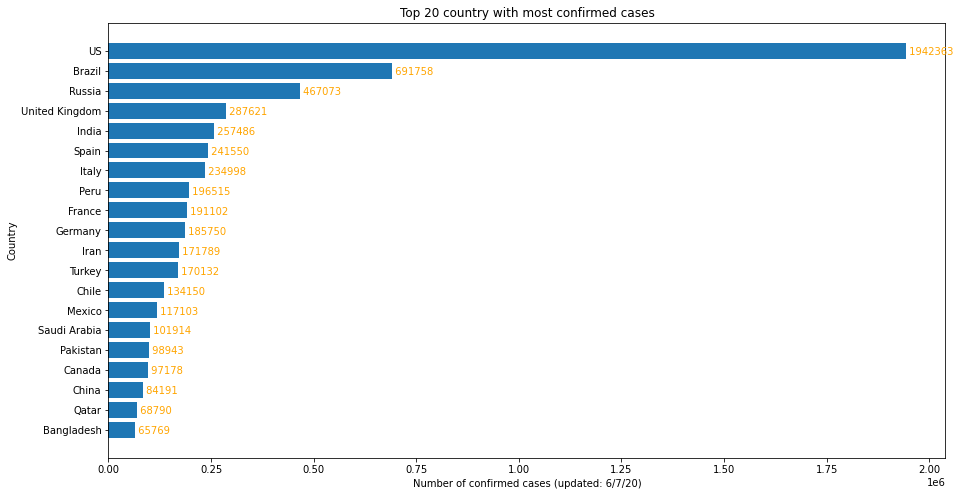

In [8]:
# Sum the amount of cases in different state group by country
df_confirmed_country = df_confirmed.groupby('Country/Region')[dates].sum().reset_index()
df_confirmed_country = df_confirmed_country.sort_values(by=df_confirmed_country.columns[-1], ascending=False)

# Plot the chart for top 20 most confirmed cases
plt.figure(figsize=(15,8))
plt.barh(df_confirmed_country[df_confirmed_country.columns[0]].iloc[:20][::-1], 
         df_confirmed_country[df_confirmed_country.columns[-1]].iloc[:20][::-1])
for i, v in enumerate(df_confirmed_country[df_confirmed_country.columns[-1]].iloc[:20][::-1]):
    plt.text(v, i-.2, ' '+str(v), color='orange')
plt.title('Top 20 country with most confirmed cases')
plt.ylabel('Country')
plt.xlabel(f'Number of confirmed cases (updated: {df_confirmed_country.columns[-1]})')

Text(0.5, 0, 'Number of death cases (updated: 6/7/20)')

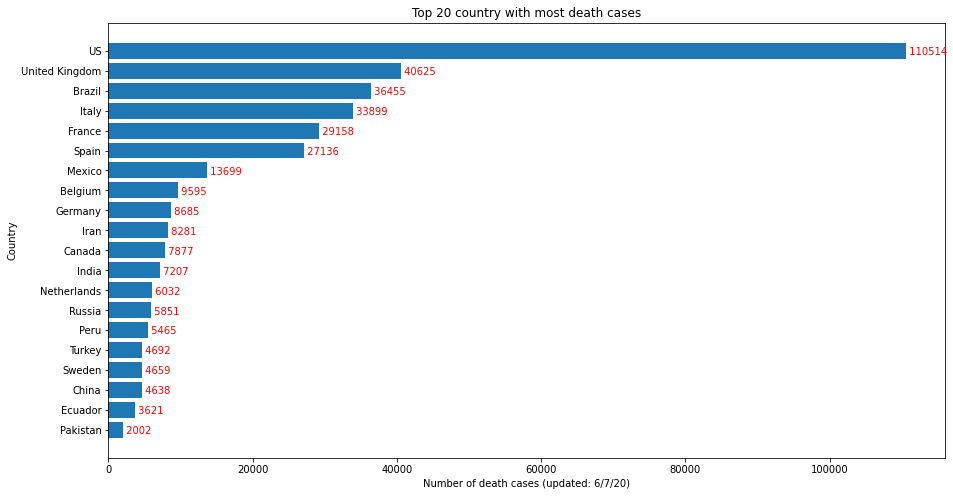

In [9]:
# Sum the amount of cases in different state group by country
df_death_country = df_death.groupby('Country/Region')[dates].sum().reset_index()
df_death_country = df_death_country.sort_values(by=df_death_country.columns[-1], ascending=False)

# Plot the chart for top 20 most death cases
plt.figure(figsize=(15,8))
plt.barh(df_death_country[df_death_country.columns[0]].iloc[:20][::-1], 
         df_death_country[df_death_country.columns[-1]].iloc[:20][::-1])
for i, v in enumerate(df_death_country[df_death_country.columns[-1]].iloc[:20][::-1]):
    plt.text(v, i-.2, ' '+str(v), color='red')
plt.title('Top 20 country with most death cases')
plt.ylabel('Country')
plt.xlabel(f'Number of death cases (updated: {df_death_country.columns[-1]})')

Text(0.5, 0, 'Number of recovered cases (updated: 6/7/20)')

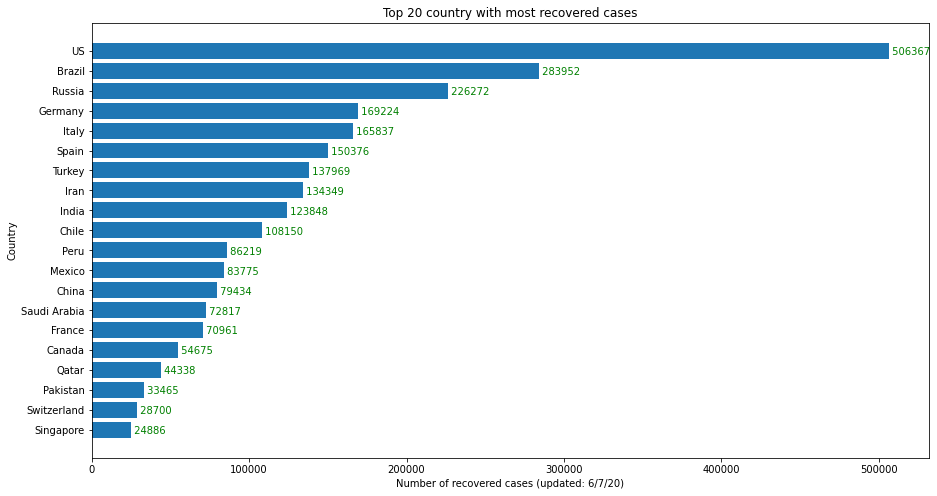

In [10]:
# Sum the amount of cases in different state group by country
df_recovered_country = df_recovered.groupby('Country/Region')[dates].sum().reset_index()
df_recovered_country = df_recovered_country.sort_values(by=df_recovered_country.columns[-1], ascending=False)

# Plot the chart for top 20 most recovered cases
plt.figure(figsize=(15,8))
plt.barh(df_recovered_country[df_recovered_country.columns[0]].iloc[:20][::-1], 
         df_recovered_country[df_recovered_country.columns[-1]].iloc[:20][::-1])
for i, v in enumerate(df_recovered_country[df_recovered_country.columns[-1]].iloc[:20][::-1]):
    plt.text(v, i-.2, ' '+str(v), color='green')
plt.title('Top 20 country with most recovered cases')
plt.ylabel('Country')
plt.xlabel(f'Number of recovered cases (updated: {df_recovered_country.columns[-1]})')

In [11]:
# Aggregate the latest number for confirmed, death and recovered cases for each country
df_agg = df_confirmed_country.iloc[:,[0,-1]].rename(columns={'Country/Region':'country',dates[-1]:'confirmed'})
df_agg = df_agg.join(df_death_country.iloc[:,[0,-1]].set_index('Country/Region'), 
                     on='country').rename(columns={dates[-1]:'death'})
df_agg = df_agg.join(df_recovered_country.iloc[:,[0,-1]].set_index('Country/Region'), 
                     on='country').rename(columns={dates[-1]:'recovered'})
df_agg.head(2)

,country,confirmed,death,recovered
174,US,1942363,110514,506367
23,Brazil,691758,36455,283952


In [12]:
# Calculate the current active cases and rate of death and recovered
df_agg['current_active'] = df_agg['confirmed'] - df_agg['death'] - df_agg['recovered']
df_agg['death_rate'] = round((df_agg['death'] / df_agg['confirmed']) * 100, 2)
df_agg['recovered_rate'] = round((df_agg['recovered'] / df_agg['confirmed']) * 100, 2)
df_agg.head(2)

,country,confirmed,death,recovered,current_active,death_rate,recovered_rate
174,US,1942363,110514,506367,1325482,5.69,26.07
23,Brazil,691758,36455,283952,371351,5.27,41.05


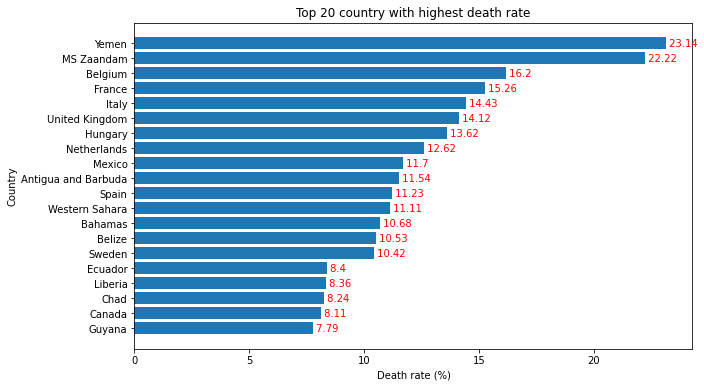

In [13]:
df_agg.sort_values(by='death_rate', inplace=True)

# Plot top 20 highest death rate
plt.figure(figsize=(10,6))
plt.barh(df_agg['country'].iloc[-20:], df_agg['death_rate'].iloc[-20:])
plt.title("Top 20 country with highest death rate")
plt.xlabel("Death rate (%)")
plt.ylabel("Country")

for i, v in enumerate(df_agg['death_rate'].iloc[-20:]):
    plt.text(v, i-.2, ' '+str(v), color='red')

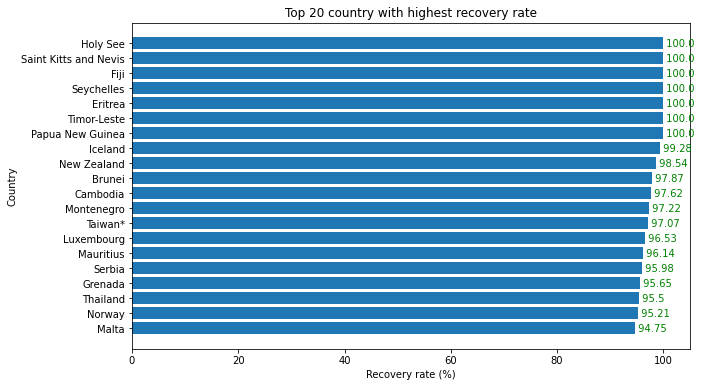

In [14]:
df_agg.sort_values(by='recovered_rate', inplace=True)

# Plot top 20 highest recovery rate
plt.figure(figsize=(10,6))
plt.barh(df_agg['country'].iloc[-20:], df_agg['recovered_rate'].iloc[-20:])
plt.title("Top 20 country with highest recovery rate")
plt.xlabel("Recovery rate (%)")
plt.ylabel("Country")

for i, v in enumerate(df_agg['recovered_rate'].iloc[-20:]):
    plt.text(v, i-.2, ' '+str(v), color='green')

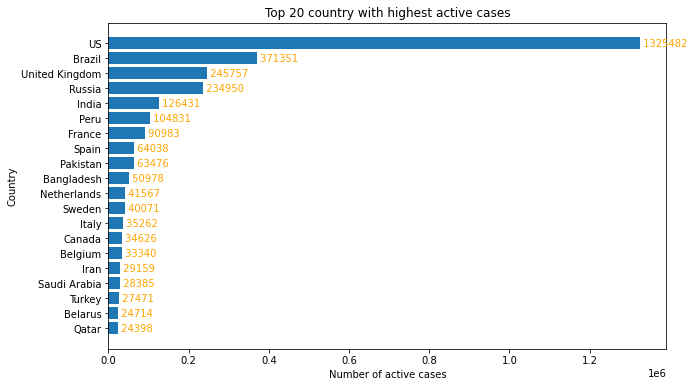

In [15]:
df_agg.sort_values(by='current_active', inplace=True)

# Plot top 20 highest active case
plt.figure(figsize=(10,6))
plt.barh(df_agg['country'].iloc[-20:], df_agg['current_active'].iloc[-20:])
plt.title("Top 20 country with highest active cases")
plt.xlabel("Number of active cases")
plt.ylabel("Country")

for i, v in enumerate(df_agg['current_active'].iloc[-20:]):
    plt.text(v, i-.2, ' '+str(v), color='orange')

In [16]:
df_agg.sort_values(by='current_active', ascending=False, inplace=True)
df_agg.style.background_gradient(cmap='Reds')

,country,confirmed,death,recovered,current_active,death_rate,recovered_rate
174,US,1942363,110514,506367,1325482,5.690000,26.070000
23,Brazil,691758,36455,283952,371351,5.270000,41.050000
178,United Kingdom,287621,40625,1239,245757,14.120000,0.430000
140,Russia,467073,5851,226272,234950,1.250000,48.440000
79,India,257486,7207,123848,126431,2.800000,48.100000
134,Peru,196515,5465,86219,104831,2.780000,43.870000
62,France,191102,29158,70961,90983,15.260000,37.130000
158,Spain,241550,27136,150376,64038,11.230000,62.250000
130,Pakistan,98943,2002,33465,63476,2.020000,33.820000
13,Bangladesh,65769,888,13903,50978,1.350000,21.140000


### Malaysia Cases Analytic

In [0]:
# Extract Malaysia time series data
my_confirmed = df_confirmed[df_confirmed['Country/Region'] == 'Malaysia'][dates].values.flatten()
my_recovered = df_recovered[df_recovered['Country/Region'] == 'Malaysia'][dates].values.flatten()
my_death = df_death[df_death['Country/Region'] == 'Malaysia'][dates].values.flatten()
my_active = my_confirmed - my_recovered - my_death

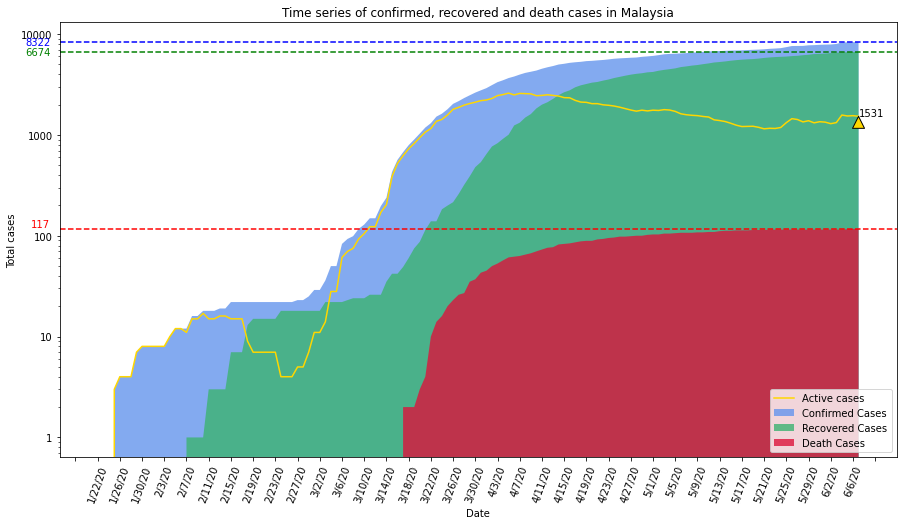

In [18]:
# Plot chart of cases in Malaysia
plt.figure(figsize=(15,8))

plt.fill_between(dates, my_confirmed, facecolor='cornflowerBlue', alpha=0.8, label='Confirmed Cases')
plt.fill_between(dates, my_recovered, facecolor='mediumSeaGreen', alpha=0.8, label='Recovered Cases')
plt.fill_between(dates, my_death, facecolor='crimson', alpha=0.8, label='Death Cases')
plt.plot(dates, my_active, color='gold', label='Active cases')

plt.axhline(y=my_confirmed[-1], color='blue', linestyle='--')
plt.axhline(y=my_recovered[-1], color='green', linestyle='--')
plt.axhline(y=my_death[-1], color='red', linestyle='--')
plt.text(int(len(dates)/-10), my_confirmed[-1], my_confirmed[-1], color='blue', va='center')
plt.text(int(len(dates)/-10), my_recovered[-1], my_recovered[-1], color='green', va='center')
plt.text(int(len(dates)/-11), my_death[-1] + 5, my_death[-1], color='red')
plt.annotate(s=my_active[-1], xy=(dates[-1], my_active[-1]), arrowprops=dict(facecolor='gold', shrink=0.05))

plt.yscale('log')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=50))
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.xticks(rotation=70)
plt.title('Time series of confirmed, recovered and death cases in Malaysia')
plt.xlabel('Date')
plt.ylabel('Total cases')
plt.legend()

## Prediction

### Predictive Model for Malaysia cases

In [0]:
def gru_model(sequence):
  keras.backend.clear_session()

  in_data = keras.Input((sequence, 1),dtype='float32')

  X = keras.layers.GRU(256, return_sequences=True)(in_data)
  # X = keras.layers.Dropout(0.2)(X)
  X = keras.layers.GRU(128, return_sequences=True)(X)
  # X = keras.layers.Flatten()(X)
  # X = keras.layers.Dropout(0.2)(X)
  X = keras.layers.GRU(64)(X)
  # X = keras.layers.Dropout(0.2)(X)
  X = keras.layers.Dense(128, activation='relu')(X)
  X = keras.layers.Dense(64, activation='relu')(X)
  X = keras.layers.Dense(1, activation='relu')(X)

  # Create Model instance which converts sentence_indices into X.
  model = keras.models.Model(inputs=in_data, outputs=X)
  print(model.summary())
  return model

In [180]:
# Create training input for lstm
sample_confirmed = np.pad(my_confirmed, (prev_day,0), 'constant', constant_values=0).reshape(my_confirmed.shape[0]+prev_day, 1)
sample_confirmed = [sample_confirmed[i:i+prev_day]for i in range(0, len(sample_confirmed)-prev_day,1)]
sample_confirmed = np.array(sample_confirmed).reshape(len(sample_confirmed),prev_day,1).astype(float)
sample_recovered = np.pad(my_recovered, (prev_day,0), 'constant', constant_values=0).reshape(my_recovered.shape[0]+prev_day, 1)
sample_recovered = [sample_recovered[i:i+prev_day]for i in range(0, len(sample_recovered)-prev_day,1)]
sample_recovered = np.array(sample_recovered).reshape(len(sample_recovered),prev_day,1).astype(float)
sample_death = np.pad(my_death, (prev_day,0), 'constant', constant_values=0).reshape(my_death.shape[0]+prev_day, 1)
sample_death = [sample_death[i:i+prev_day]for i in range(0, len(sample_death)-prev_day,1)]
sample_death = np.array(sample_death).reshape(len(sample_death),prev_day,1).astype(float)
# features = np.concatenate((sample_confirmed, sample_recovered, sample_death), axis=2)

# Create training input for ff network
# sample_confirmed = np.array(my_confirmed).reshape(len(my_confirmed),1).astype(float)
# sample_recovered = np.array(my_recovered).reshape(len(my_recovered),1).astype(float)
# sample_death = np.array(my_death).reshape(len(my_death),1).astype(float)
# features = np.concatenate((sample_confirmed, sample_recovered, sample_death), axis=1)

# Create label
label_confirmed = np.array(my_confirmed).reshape(len(my_confirmed),1).astype(float)
label_recovered = np.array(my_recovered).reshape(len(my_recovered),1).astype(float)
label_death = np.array(my_death).reshape(len(my_death),1).astype(float)
# label = np.concatenate((label_confirmed, label_recovered, label_death), axis=1)

# X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.1)
# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# X_train = features[:-1]
# y_train = label[1:]
# # X_train, y_train = shuffle(X_train, y_train)
# print(X_train.shape, y_train.shape)
print(f'Confirmed -> sample shape: {sample_confirmed.shape} label shape: {label_confirmed.shape}')
print(f'Recovered -> sample shape: {sample_recovered.shape} label shape: {label_recovered.shape}')
print(f'Death -> sample shape: {sample_death.shape} label shape: {label_death.shape}')

Confirmed -> sample shape: (138, 14, 1) label shape: (138, 1)
Recovered -> sample shape: (138, 14, 1) label shape: (138, 1)
Death -> sample shape: (138, 14, 1) label shape: (138, 1)


In [0]:
# previous sequences used in LSTM
prev_day = 14

##### Confirmed cases model

In [0]:
model_confirmed = gru_model(prev_day)
model_confirmed.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

In [0]:
epochs = 1000
batch_size = 64
mh_confirmed = {
    'loss': [],
    'val_loss': []
}

Epoch 100 -> loss: [8366.8447265625] val_loss: [8775.609375]
Epoch 200 -> loss: [3696.8583984375] val_loss: [5971.06689453125]
Epoch 300 -> loss: [18237.908203125] val_loss: [8199.142578125]
Epoch 400 -> loss: [36737.4609375] val_loss: [61553.16015625]
Epoch 500 -> loss: [2524.2841796875] val_loss: [4261.90576171875]
Epoch 600 -> loss: [36909.69921875] val_loss: [93506.6328125]
Epoch 700 -> loss: [4630.98681640625] val_loss: [7854.4423828125]
Epoch 800 -> loss: [23832.73828125] val_loss: [4600.87255859375]
Epoch 900 -> loss: [1998.8616943359375] val_loss: [4635.95654296875]
Epoch 1000 -> loss: [2722.65869140625] val_loss: [4454.5791015625]



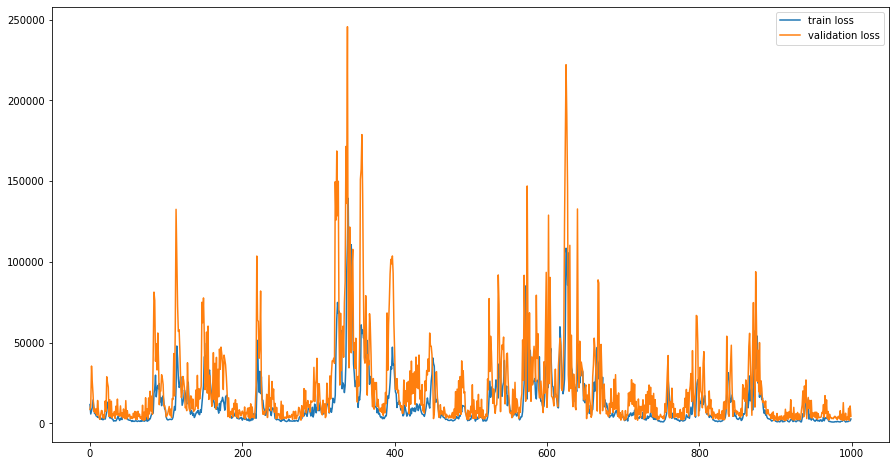

In [185]:
shuffled_sample_confirmed, shuffled_label_confirmed = shuffle(sample_confirmed, label_confirmed)
for i in tqdm(range(epochs)):
  history = model_confirmed.fit(x=shuffled_sample_confirmed, y=shuffled_label_confirmed, 
                      epochs=1, 
                      batch_size=batch_size, 
                      validation_split=0.1,
                      shuffle=True,
                      verbose=0)
  mh_confirmed['loss'].append(history.history['loss'])
  mh_confirmed['val_loss'].append(history.history['val_loss'])
  if((int((i+1)%(epochs/10)) == 0) or (i == (epochs-1))):
    print(f"Epoch {i+1} -> loss: {history.history['loss']} val_loss: {history.history['val_loss']}")

# Plot model traning loss
plt.figure(figsize=(15,8))
plt.plot(mh_confirmed['loss'], label='train loss')
plt.plot(mh_confirmed['val_loss'], label='validation loss')
plt.legend()

In [0]:
pred_confirmed = model_confirmed.predict(sample_confirmed)

# Forecasting day
forecast_days = 30

pred_feature = sample_confirmed[-1:]
pred_feature = np.concatenate((pred_feature[:,1:,:], pred_confirmed[-1].reshape((1,1,1))),axis=1)
# pred_feature = pred_confirmed[-1:]
pred_date = dates


for day in range(forecast_days):
    pred = model_confirmed.predict(pred_feature)
    pred_confirmed = np.concatenate((pred_confirmed, pred), axis=0)
    pred_date = pred_date + [(datetime.strptime(pred_date[-1], '%x') + timedelta(days=1)).strftime("%x")]
    pred_feature = np.concatenate((pred_feature[:,1:,:], pred.reshape((1,1,1))),axis=1) 
    # pred_feature = pred_confirmed[-1:]
    

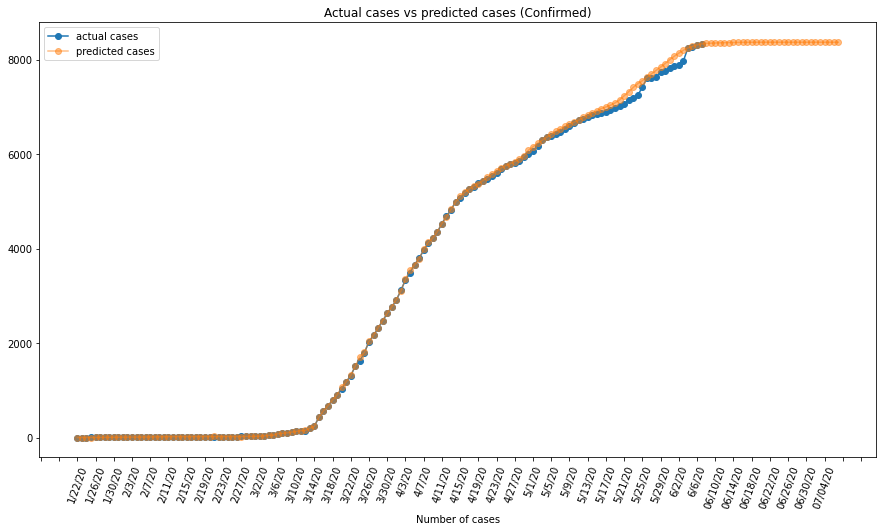

In [191]:
plt.figure(figsize=(15,8))
plt.plot(dates, my_confirmed, marker='o', label='actual cases')
plt.plot(pred_date, pred_confirmed, marker='o', label='predicted cases', alpha=0.5)
plt.title("Actual cases vs predicted cases (Confirmed)")
plt.xlabel('Date')
plt.xlabel('Number of cases')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=50))
plt.xticks(rotation=70)
plt.legend()

In [227]:
model_recovered.save(f'{WORKING_DIR}/saved_model/model_recovered')

INFO:tensorflow:Assets written to: drive/My Drive/colab/covid-19-analysis/saved_model/model_recovered/assets


##### Recovered cases model

In [196]:
model_recovered = gru_model(prev_day)
model_recovered.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14, 1)]           0         
_________________________________________________________________
gru (GRU)                    (None, 14, 256)           198912    
_________________________________________________________________
gru_1 (GRU)                  (None, 14, 128)           148224    
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                37248     
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65    

In [0]:
epochs = 1000
batch_size = 64
mh_recovered = {
    'loss': [],
    'val_loss': []
}

Epoch 1/1000
2/2 [==============================] - 0s 22ms/step - loss: 2233.5042 - val_loss: 2967.3635
Epoch 2/1000
2/2 [==============================] - 0s 21ms/step - loss: 1906.8235 - val_loss: 205.7070
Epoch 3/1000
2/2 [==============================] - 0s 17ms/step - loss: 2786.5723 - val_loss: 2347.0200
Epoch 4/1000
2/2 [==============================] - 0s 20ms/step - loss: 2372.2368 - val_loss: 181.6401
Epoch 5/1000
2/2 [==============================] - 0s 17ms/step - loss: 1367.1510 - val_loss: 2666.6848
Epoch 6/1000
2/2 [==============================] - 0s 18ms/step - loss: 1257.4761 - val_loss: 592.8984
Epoch 7/1000
2/2 [==============================] - 0s 19ms/step - loss: 2545.9814 - val_loss: 1961.9855
Epoch 8/1000
2/2 [==============================] - 0s 20ms/step - loss: 3292.8025 - val_loss: 840.5316
Epoch 9/1000
2/2 [==============================] - 0s 21ms/step - loss: 8511.0303 - val_loss: 3074.6675
Epoch 10/1000
2/2 [==============================] - 0s 18m

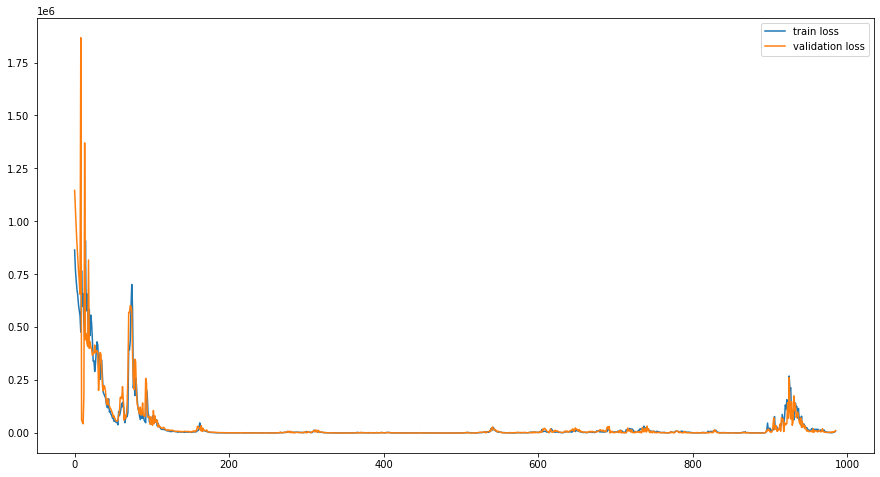

In [215]:
shuffled_sample_recovered, shuffled_label_recovered = shuffle(sample_recovered, label_recovered)
early_stopping_monitor = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=100,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)
history = model_recovered.fit(x=shuffled_sample_recovered, y=shuffled_label_recovered, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    validation_split=0.1,
                    shuffle=True,
                    callbacks=[early_stopping_monitor],
                    verbose=1)

mh_recovered['loss'].extend(history.history['loss'])
mh_recovered['val_loss'].extend(history.history['val_loss'])

# Plot model traning loss
plt.figure(figsize=(15,8))
plt.plot(mh_recovered['loss'], label='train loss')
plt.plot(mh_recovered['val_loss'], label='validation loss')
plt.legend()

In [0]:
pred_recovered = model_recovered.predict(sample_recovered)

# Forecasting day
forecast_days = 30

pred_feature = sample_recovered[-1:]
pred_feature = np.concatenate((pred_feature[:,1:,:], pred_recovered[-1].reshape((1,1,1))),axis=1)
pred_date = dates


for day in range(forecast_days):
    pred = model_recovered.predict(pred_feature)
    pred_recovered = np.concatenate((pred_recovered, pred), axis=0)
    pred_date = pred_date + [(datetime.strptime(pred_date[-1], '%x') + timedelta(days=1)).strftime("%x")]
    pred_feature = np.concatenate((pred_feature[:,1:,:], pred.reshape((1,1,1))),axis=1) 

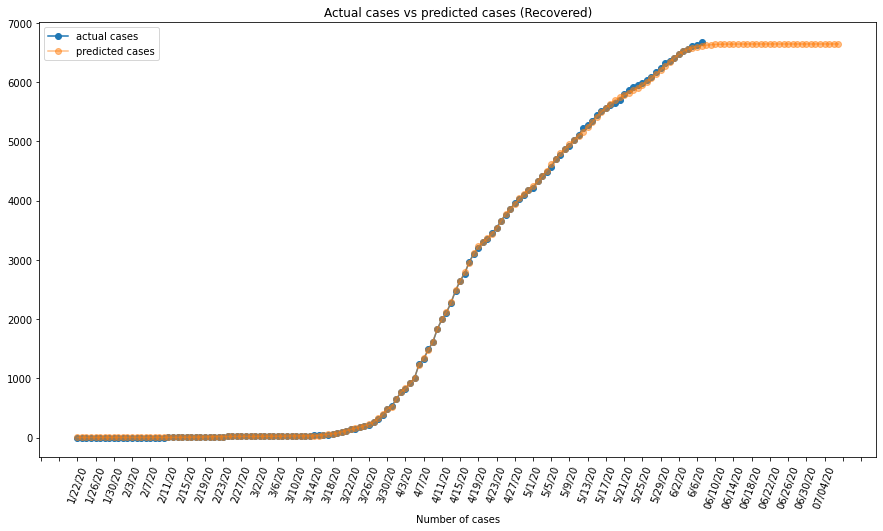

In [217]:
plt.figure(figsize=(15,8))
plt.plot(dates, my_recovered, marker='o', label='actual cases')
plt.plot(pred_date, pred_recovered, marker='o', label='predicted cases', alpha=0.5)
plt.title("Actual cases vs predicted cases (Recovered)")
plt.xlabel('Date')
plt.xlabel('Number of cases')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=50))
plt.xticks(rotation=70)
plt.legend()

In [225]:
model_recovered.save(f'{WORKING_DIR}/saved_model/model_recovered')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: drive/My Drive/colab/covid-19-analysis/saved_model/model_recovered/assets


##### Death cases model

In [218]:
model_death = gru_model(prev_day)
model_death.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14, 1)]           0         
_________________________________________________________________
gru (GRU)                    (None, 14, 256)           198912    
_________________________________________________________________
gru_1 (GRU)                  (None, 14, 128)           148224    
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                37248     
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65    

In [0]:
epochs = 1000
batch_size = 64
mh_death = {
    'loss': [],
    'val_loss': []
}

Epoch 1/1000
2/2 [==============================] - 1s 371ms/step - loss: 4567.4082 - val_loss: 7316.2056
Epoch 2/1000
2/2 [==============================] - 0s 20ms/step - loss: 4417.6885 - val_loss: 7102.3408
Epoch 3/1000
2/2 [==============================] - 0s 26ms/step - loss: 4283.7939 - val_loss: 6892.0356
Epoch 4/1000
2/2 [==============================] - 0s 20ms/step - loss: 4158.3315 - val_loss: 6672.4878
Epoch 5/1000
2/2 [==============================] - 0s 22ms/step - loss: 4009.3462 - val_loss: 6448.9766
Epoch 6/1000
2/2 [==============================] - 0s 19ms/step - loss: 3867.4319 - val_loss: 6218.2153
Epoch 7/1000
2/2 [==============================] - 0s 19ms/step - loss: 3722.2505 - val_loss: 5969.6694
Epoch 8/1000
2/2 [==============================] - 0s 21ms/step - loss: 3568.2192 - val_loss: 5701.1372
Epoch 9/1000
2/2 [==============================] - 0s 19ms/step - loss: 3393.6064 - val_loss: 5412.2544
Epoch 10/1000
2/2 [==============================] - 0

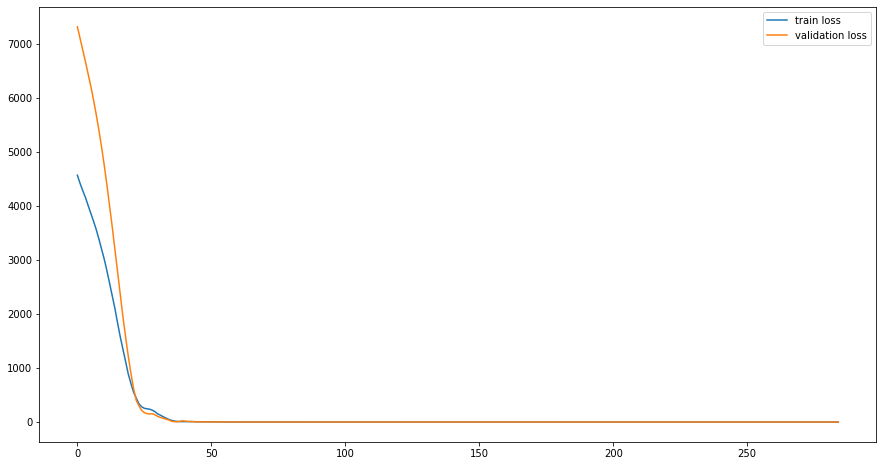

In [220]:
shuffled_sample_death, shuffled_label_death = shuffle(sample_death, label_death)
early_stopping_monitor = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=100,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)
history = model_death.fit(x=shuffled_sample_death, y=shuffled_label_death, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    validation_split=0.1,
                    shuffle=True,
                    callbacks=[early_stopping_monitor],
                    verbose=1)

mh_death['loss'].extend(history.history['loss'])
mh_death['val_loss'].extend(history.history['val_loss'])

# Plot model traning loss
plt.figure(figsize=(15,8))
plt.plot(mh_death['loss'], label='train loss')
plt.plot(mh_death['val_loss'], label='validation loss')
plt.legend()

In [0]:
pred_death = model_death.predict(sample_death)

# Forecasting day
forecast_days = 30

pred_feature = sample_death[-1:]
pred_feature = np.concatenate((pred_feature[:,1:,:], pred_death[-1].reshape((1,1,1))),axis=1)
pred_date = dates


for day in range(forecast_days):
    pred = model_death.predict(pred_feature)
    pred_death = np.concatenate((pred_death, pred), axis=0)
    pred_date = pred_date + [(datetime.strptime(pred_date[-1], '%x') + timedelta(days=1)).strftime("%x")]
    pred_feature = np.concatenate((pred_feature[:,1:,:], pred.reshape((1,1,1))),axis=1) 

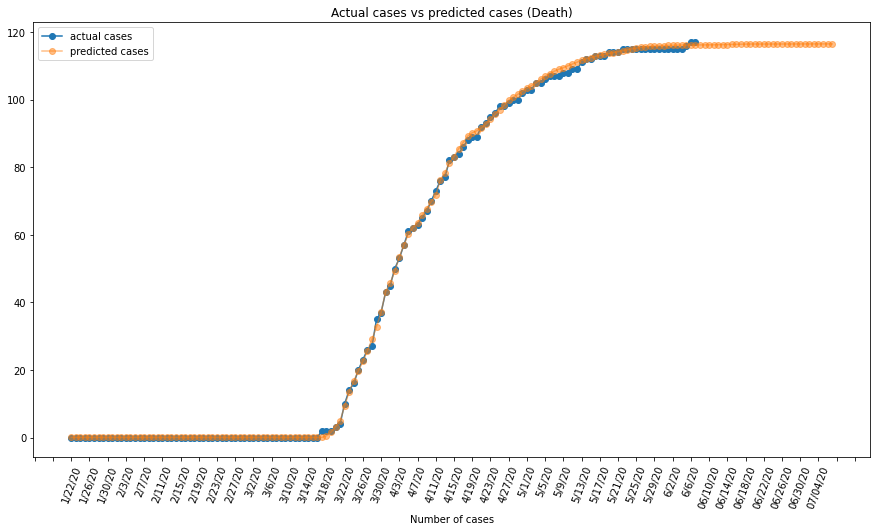

In [222]:
plt.figure(figsize=(15,8))
plt.plot(dates, my_death, marker='o', label='actual cases')
plt.plot(pred_date, pred_death, marker='o', label='predicted cases', alpha=0.5)
plt.title("Actual cases vs predicted cases (Death)")
plt.xlabel('Date')
plt.xlabel('Number of cases')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=50))
plt.xticks(rotation=70)
plt.legend()

In [226]:
model_death.save(f'{WORKING_DIR}/saved_model/model_death')

INFO:tensorflow:Assets written to: drive/My Drive/colab/covid-19-analysis/saved_model/model_death/assets
